#### Note that %pip is a special IPython magic command that is recommended for use in Jupyter notebooks, as it can help ensure that the installed packages are available in the current Jupyter kernel.

In [61]:
import os
os.environ['IS_COLAB'] = 'False'
# %pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu -q
# %pip install sklearn -q
## Only need the libraries below in Collab
# %pip install alpaca_trade_api -q
# %pip install python-dotenv -q
# %pip install ta -q


In [62]:
# print(f"ALPACA_API_KEY_ID: {os.environ.get('ALPACA_API_KEY')}")
# print(f"ALPACA_API_SECRET_KEY: {os.environ.get('ALPACA_API_SECRET')}")

In [63]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ta  # Technical Analysis Library
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
from math import sqrt
from dotenv import load_dotenv
import time
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
import requests

# load_dotenv()
# Function to check if the notebook is running on Google Colab
def is_running_on_colab():
    return os.getenv('IS_COLAB') == 'True'
    from google.colab import userdata

# Load secrets based on environment
if is_running_on_colab():
    # Load from Colab secrets
    from google.colab import userdata
    ALPACA_API_KEY_ID = userdata.get('ALPACA_API_KEY')
    ALPACA_API_SECRET_KEY = userdata.get('ALPACA_API_SECRET')
    POLYGON_API_KEY = userdata.get('POLYGON_API_KEY')
else:
    # Load from local environment variables
    ALPACA_API_KEY_ID = os.getenv("ALPACA_API_KEY")
    ALPACA_API_SECRET_KEY = os.getenv("ALPACA_API_SECRET")
    POLYGON_API_KEY = os.getenv("POLYGON_API_KEY")

target_stock = 'X:ETHUSD'
# target_stock = 'SRNE'
# target_stock = 'NVDA'

# Initialize Alpaca API
api = tradeapi.REST(ALPACA_API_KEY_ID, ALPACA_API_SECRET_KEY, 'https://paper-api.alpaca.markets')

# Fetch Data
def fetch_data(symbol, start_date, end_date):
    data = api.get_bars(symbol, TimeFrame.Minute, start_date, end_date, adjustment='raw').df

    # Add technical indicators and future close column
    # Creating 'close_future' column by shifting 'close' prices 15 minutes ahead.
    # This prepares the DataFrame for predicting stock closing prices 15 minutes into the future
    data['close_future'] = data['close'].shift(-15)
    data['rsi'] = ta.momentum.rsi(data['close'])
    data['ema'] = ta.trend.ema_indicator(data['close'])
    data['cmf'] = ta.volume.chaikin_money_flow(data['high'], data['low'], data['close'], data['volume'])
    data['vwap'] = ta.volume.volume_weighted_average_price(data['high'], data['low'], data['close'], data['volume'])
    data['bollinger_high'] = ta.volatility.bollinger_hband(data['close'])
    data['bollinger_low'] = ta.volatility.bollinger_lband(data['close'])
    data['macd'] = ta.trend.macd(data['close'])
    ichimoku = ta.trend.IchimokuIndicator(data['high'], data['low'])
    data['ichimoku_a'] = ichimoku.ichimoku_a()
    data['ichimoku_b'] = ichimoku.ichimoku_b()
    data['ichimoku_base'] = ichimoku.ichimoku_base_line()
    data['ichimoku_conversion'] = ichimoku.ichimoku_conversion_line()
    data['stoch'] = ta.momentum.stoch(data['high'], data['low'], data['close'])

    data.dropna(inplace=True)
    return data

### Uncomment the line below to use Alpaca ############################################################
# Using polygon now
# train_data = fetch_data(target_stock, '2020-01-01', '2020-07-01')
# test_data = fetch_data(target_stock, '2020-07-02', '2020-07-03')

# train_data = fetch_data(target_stock, '2019-12-18', '2019-12-31')
# test_data = fetch_data(target_stock, '2020-01-01', '2023-12-26')

# train_data = fetch_data(target_stock, '2023-10-01', '2023-11-01')
# test_data = fetch_data(target_stock, '2023-11-02', '2023-12-26')

# Assuming train_data and test_data are pandas DataFrames already defined and have a 'close' column.

# Print the columns of the DataFrame to verify its structure
# print(f"Number of Train Data: {train_data.columns}")
############################################################################################################

def fetch_polygon_data(symbol, start_date, end_date, apiKey):
    #Reference for info https://polygon.io/docs/crypto/get_v2_aggs_ticker__cryptoticker__range__multiplier___timespan___from___to
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/minute/{start_date}/{end_date}?apiKey={apiKey}"
    # print(url)
    # url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/minute/{start_date}/{end_date}?apiKey={apiKey}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        print(data)
        df = pd.DataFrame(data['results'])
        df.rename(columns={'t': 'timestamp', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'}, inplace=True)
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        
        # Add technical indicators
        # Creating 'close_future' column by shifting 'close' prices 15 minutes ahead.
        # This prepares the DataFrame for predicting stock closing prices 15 minutes into the future
        df['close_future'] = df['close'].shift(-15)
        df['rsi'] = ta.momentum.rsi(df['close'])
        df['ema'] = ta.trend.ema_indicator(df['close'])
        df['cmf'] = ta.volume.chaikin_money_flow(df['high'], df['low'], df['close'], df['volume'])
        df['vwap'] = ta.volume.volume_weighted_average_price(df['high'], df['low'], df['close'], df['volume'])
        df['bollinger_high'] = ta.volatility.bollinger_hband(df['close'])
        df['bollinger_low'] = ta.volatility.bollinger_lband(df['close'])
        df['macd'] = ta.trend.macd(df['close'])
        ichimoku = ta.trend.IchimokuIndicator(df['high'], df['low'])
        df['ichimoku_a'] = ichimoku.ichimoku_a()
        df['ichimoku_b'] = ichimoku.ichimoku_b()
        df['ichimoku_base'] = ichimoku.ichimoku_base_line()
        df['ichimoku_conversion'] = ichimoku.ichimoku_conversion_line()
        df['stoch'] = ta.momentum.stoch(df['high'], df['low'], df['close'])

        df.dropna(inplace=True)
        return df
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

# Example usage
train_data = fetch_polygon_data(target_stock, '2023-05-01', '2023-07-01', POLYGON_API_KEY)
test_data = fetch_polygon_data(target_stock, '2023-07-02', '2023-07-03', POLYGON_API_KEY)

{'ticker': 'X:ETHUSD', 'queryCount': 5000, 'resultsCount': 5000, 'adjusted': True, 'results': [{'v': 488.7724670799995, 'vw': 1871.3109, 'o': 1869.58, 'c': 1871.46, 'h': 1873.2, 'l': 1869.58, 't': 1682899200000, 'n': 585}, {'v': 1355.4904251799987, 'vw': 1876.1895, 'o': 1871.8, 'c': 1877.16, 'h': 1878.61, 'l': 1871.17, 't': 1682899260000, 'n': 625}, {'v': 143.93847204, 'vw': 1876.0589, 'o': 1877.26, 'c': 1875.02, 'h': 1878, 'l': 1874.98, 't': 1682899320000, 'n': 315}, {'v': 114.89806739, 'vw': 1876.7078, 'o': 1874.76, 'c': 1879.3, 'h': 1879.31, 'l': 1874.3, 't': 1682899380000, 'n': 247}, {'v': 238.6345408100002, 'vw': 1880.9122, 'o': 1879.15, 'c': 1881.91, 'h': 1882.7, 'l': 1878.22, 't': 1682899440000, 'n': 416}, {'v': 64.93870886000002, 'vw': 1880.8856, 'o': 1882.12, 'c': 1880.48, 'h': 1882.5, 'l': 1880.05, 't': 1682899500000, 'n': 208}, {'v': 59.387740500000035, 'vw': 1879.8714, 'o': 1880.78, 'c': 1879.91, 'h': 1881.5, 'l': 1879.1, 't': 1682899560000, 'n': 211}, {'v': 37.388623, 'vw'

In [64]:
# Print the last 5 rows of test_data to verify its structure
test_data.head(5)


,volume,vw,open,close,high,low,timestamp,n,date,close_future,...,cmf,vwap,bollinger_high,bollinger_low,macd,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion,stoch
25,67.147653,1919.8763,1919.80,1919.70,1920.22,1919.26,1688257500000,160,2023-07-02 00:25:00,1921.17,...,0.050377,1921.462525,1924.341582,1919.253418,-0.947251,1921.60,1922.15,1922.15,1921.05,21.666667
26,32.470191,1920.4356,1919.71,1920.06,1921.07,1919.71,1688257560000,100,2023-07-02 00:26:00,1920.45,...,0.064873,1921.334304,1924.304559,1919.045441,-0.945203,1921.60,1922.15,1922.15,1921.05,27.666667
27,10.183968,1920.7418,1920.15,1920.77,1921.09,1920.15,1688257620000,72,2023-07-02 00:27:00,1921.66,...,-0.044821,1921.310819,1924.064144,1919.016856,-0.876188,1921.60,1922.15,1922.15,1921.05,39.500000
28,31.049069,1922.6185,1920.77,1923.10,1923.50,1920.75,1688257680000,157,2023-07-02 00:28:00,1921.56,...,-0.054061,1921.303804,1924.001914,1919.046086,-0.626263,1921.60,1922.15,1922.15,1921.05,78.333333
29,309.838270,1925.0101,1923.28,1924.52,1927.70,1923.28,1688257740000,489,2023-07-02 00:29:00,1921.35,...,-0.125992,1922.178226,1924.167707,1918.944293,-0.310039,1923.05,1923.05,1923.05,1923.05,65.806452


In [65]:
#print columns of test_data
print(f"Number of Test Data: {test_data.columns}")

Number of Test Data: Index(['volume', 'vw', 'open', 'close', 'high', 'low', 'timestamp', 'n',
       'date', 'close_future', 'rsi', 'ema', 'cmf', 'vwap', 'bollinger_high',
       'bollinger_low', 'macd', 'ichimoku_a', 'ichimoku_b', 'ichimoku_base',
       'ichimoku_conversion', 'stoch'],
      dtype='object')


In [66]:
# Print the last 5 rows of test_data to verify its structure
# test_data_polygon.head(5)

In [67]:
#print columns of test_data
# print(f"Number of Polygon Test Data: {test_data_polygon.columns}")

## Feature Selection
### Feature selection involves choosing only the most significant features that contribute to the prediction. Calculate the correlation matrix and drop features that are highly correlated with others.

In [68]:
# Exclude 'close_future' and close when calculating the correlation matrix
features = train_data.drop(columns=['close_future','close'])
correlation_matrix = features.corr()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]


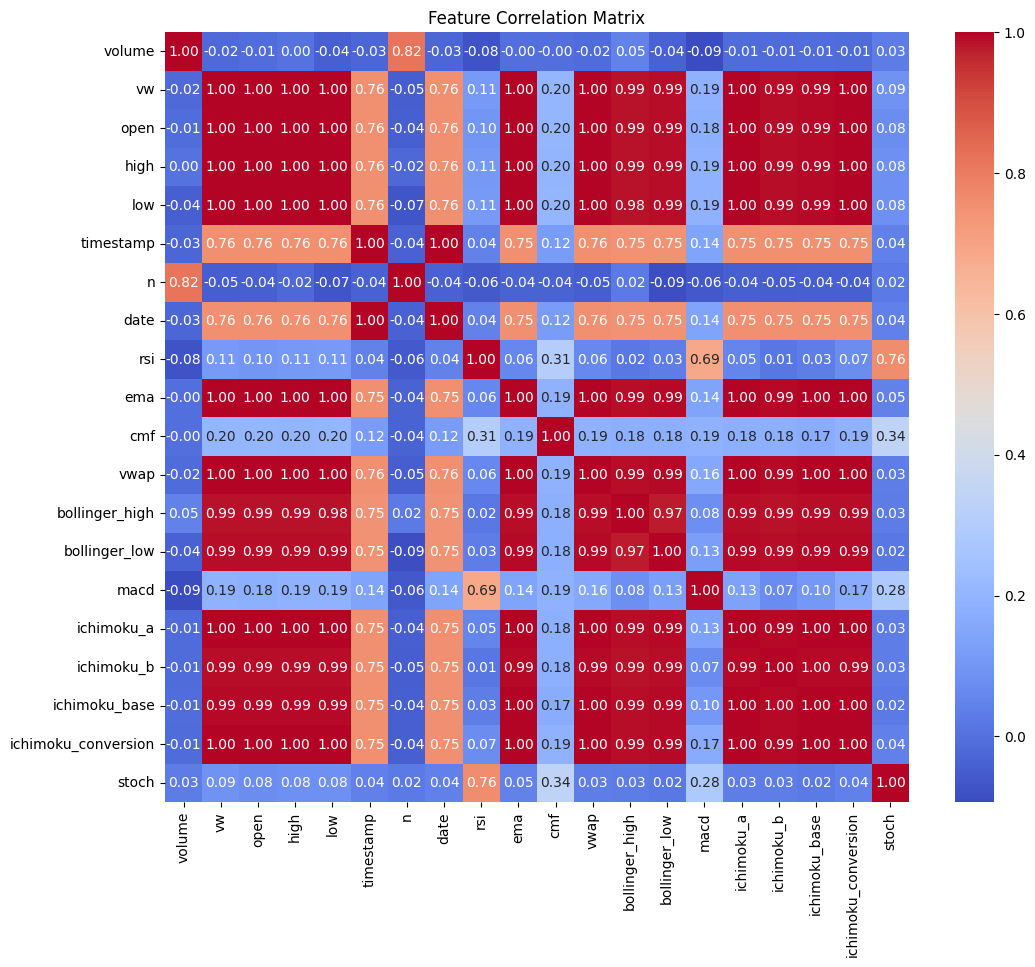

In [69]:
# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [70]:
# Drop highly correlated features
# Commented out because the when I use polygon, it breaks the LSTM code
# train_data = train_data.drop(columns=high_correlation_features)
# test_data = test_data.drop(columns=high_correlation_features)

In [71]:
#print the last 10 rows of the train_data DataFrame
train_data.tail(16)

,volume,vw,open,close,high,low,timestamp,n,date,close_future,...,cmf,vwap,bollinger_high,bollinger_low,macd,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion,stoch
4969,23.339885,1910.8787,1911.53,1910.87,1912.70,1910.54,1683197340000,127,2023-05-04 10:49:00,1910.39,...,0.252670,1914.047526,1917.384071,1907.201929,1.400081,1912.3900,1910.235,1911.800,1912.980,5.108359
4970,14.360681,1910.9665,1910.81,1910.61,1912.10,1910.61,1683197400000,99,2023-05-04 10:50:00,1911.40,...,0.238495,1913.924355,1917.203240,1907.634760,1.173623,1912.5950,1910.235,1912.210,1912.980,1.136364
4971,25.746847,1910.1960,1910.70,1909.91,1911.90,1909.40,1683197460000,136,2023-05-04 10:51:00,1911.59,...,0.229576,1913.597785,1916.983148,1908.062852,0.926983,1912.3100,1910.235,1912.210,1912.410,6.986301
4972,27.669232,1909.8002,1910.04,1909.75,1910.60,1909.43,1683197520000,127,2023-05-04 10:52:00,1911.98,...,0.224200,1913.163050,1916.621636,1908.675364,0.710419,1912.3100,1910.235,1912.210,1912.410,5.303030
4973,17.760559,1910.7352,1910.33,1910.43,1912.00,1909.75,1683197580000,112,2023-05-04 10:53:00,1911.65,...,0.201142,1912.940225,1916.600592,1908.726408,0.586895,1912.3100,1910.235,1912.210,1912.410,17.109635
4974,7.394629,1911.2116,1910.89,1911.74,1912.10,1910.66,1683197640000,86,2023-05-04 10:54:00,1911.45,...,0.184627,1912.942700,1916.598512,1908.762488,0.587931,1912.3525,1910.235,1912.355,1912.350,38.870432
4975,25.695584,1912.7551,1912.80,1913.05,1914.10,1911.53,1683197700000,142,2023-05-04 10:55:00,1911.98,...,-0.237747,1912.841691,1915.882220,1909.086780,0.686544,1912.1600,1910.235,1912.570,1911.750,60.631229
4976,18.881243,1913.8603,1913.34,1913.56,1914.80,1913.04,1683197760000,100,2023-05-04 10:56:00,1912.00,...,-0.112535,1912.865698,1915.926022,1909.086978,0.796664,1912.3650,1910.235,1912.630,1912.100,69.102990
4977,21.863537,1913.8442,1913.65,1913.98,1914.29,1913.21,1683197820000,100,2023-05-04 10:57:00,1912.52,...,-0.213745,1912.830130,1915.525214,1909.290786,0.907367,1912.3650,1910.235,1912.630,1912.100,76.079734
4978,55.551786,1913.3737,1913.59,1913.10,1913.59,1913.05,1683197880000,109,2023-05-04 10:58:00,1912.92,...,-0.252072,1912.845484,1915.173274,1909.434726,0.913559,1912.5350,1910.235,1912.970,1912.100,61.461794


Calculated NUM_FEATURES: 21
Using device: mps
Processing window 1/190
Window 1, Epoch 0/100, Loss: 0.191929, Iterations/s: 83.80
Processing window 2/190
Window 2, Epoch 0/100, Loss: 0.002245, Iterations/s: 105.59
Processing window 3/190
Window 3, Epoch 0/100, Loss: 0.001321, Iterations/s: 112.04
Processing window 4/190
Window 4, Epoch 0/100, Loss: 0.001205, Iterations/s: 113.10
Processing window 5/190
Window 5, Epoch 0/100, Loss: 0.001175, Iterations/s: 105.02
Processing window 6/190
Window 6, Epoch 0/100, Loss: 0.001151, Iterations/s: 105.39
Processing window 7/190
Window 7, Epoch 0/100, Loss: 0.001123, Iterations/s: 106.19
Processing window 8/190
Window 8, Epoch 0/100, Loss: 0.001089, Iterations/s: 118.58
Processing window 9/190
Window 9, Epoch 0/100, Loss: 0.001035, Iterations/s: 109.15
Processing window 10/190
Window 10, Epoch 0/100, Loss: 0.000972, Iterations/s: 117.63
Processing window 11/190
Window 11, Epoch 0/100, Loss: 0.000928, Iterations/s: 117.41
Processing window 12/190
Wi

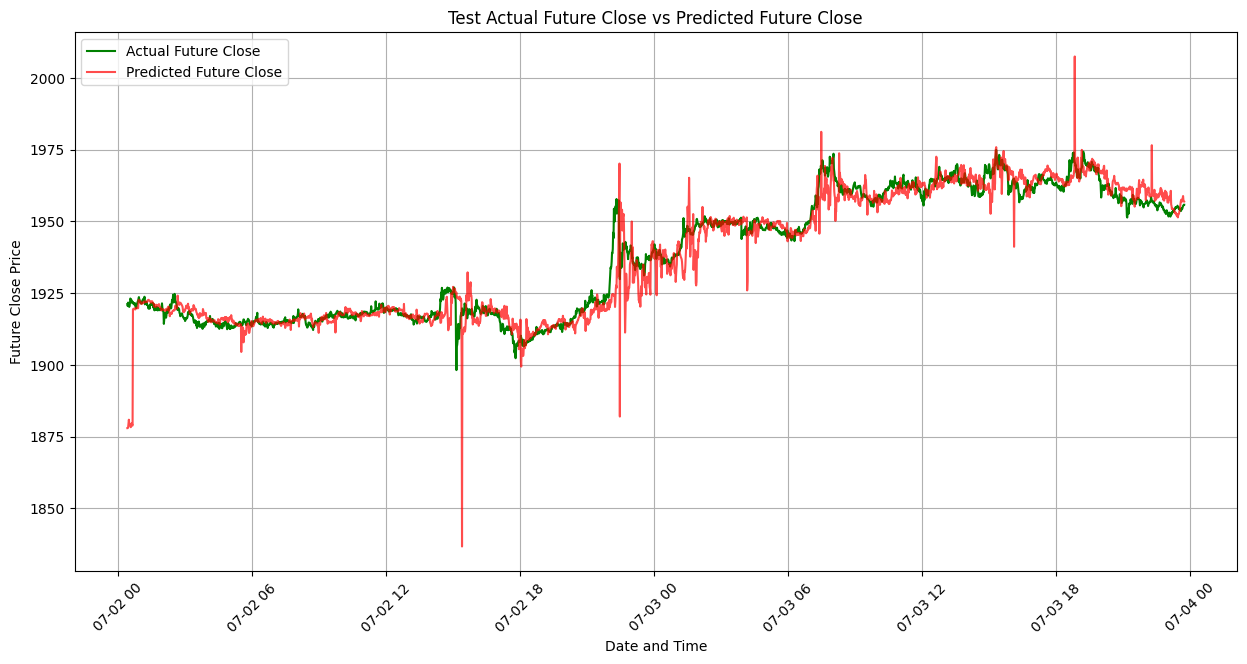

In [72]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time

# Define the window size and the number of features
WINDOW_SIZE = 15
NUM_FEATURES = len(train_data.columns) - 1  # Adjust based on the actual number of features

# Initialize the LSTM model
hidden_size = 50
num_layers = 3
output_size = 1
dropout_probability = 0.5  # Choose a value for dropout

# Training parameters
n_epochs = 100
learning_rate = 0.001

# Now print NUM_FEATURES to verify it's correct
print(f"Calculated NUM_FEATURES: {NUM_FEATURES}")

# Standardize the training data and normalize the target variable
ss = StandardScaler()
mm = MinMaxScaler()

# Make sure 'ds' column is created before running the rolling window loop
train_data['ds'] = train_data.index
test_data['ds'] = test_data.index

# LSTM model definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Training function
def train_model(model, optimiser, loss_fn, X_train, y_train, n_epochs, window_num):
    y_train = y_train.view(-1, 1)
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        optimiser.zero_grad()
        outputs = model(X_train)
        if outputs.shape != y_train.shape:
            outputs = outputs.view(*y_train.shape)

        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimiser.step()
        end_time = time.time()

        iteration_time = end_time - start_time
        iterations_per_second = 1 / iteration_time

        if epoch % 100 == 0:
            print(f'Window {window_num}, Epoch {epoch}/{n_epochs}, Loss: {loss.item():.6f}, Iterations/s: {iterations_per_second:.2f}')

# Select the device for training
# Check for available devices in order of preference: CUDA, MPS, then CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Initialize the LSTM model
model = LSTM(NUM_FEATURES, hidden_size, num_layers, output_size).to(device)

# Define the loss function and the optimizer
loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

# Rolling window prediction and training
predictions = []

for i in range(0, len(test_data), WINDOW_SIZE):
    window_num = i // WINDOW_SIZE + 1
    print(f"Processing window {window_num}/{len(test_data)//WINDOW_SIZE + (len(test_data) % WINDOW_SIZE > 0)}")

    end_idx = i + WINDOW_SIZE

    # Prepare training data
    train_window = train_data.copy()
    # Drop non-numeric columns
    train_window_numeric = train_window.select_dtypes(include=[np.number])

    X_train_scaled = ss.fit_transform(train_window_numeric.drop(columns=['close_future']))
    y_train_scaled = mm.fit_transform(train_window_numeric[['close_future']])

    # Convert to tensors
    X_train_tensors = Variable(torch.Tensor(X_train_scaled)).to(device)
    y_train_tensors = Variable(torch.Tensor(y_train_scaled)).to(device)

    # Reshape for LSTM input
    X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    y_train_tensors_final = torch.reshape(y_train_tensors, (y_train_tensors.shape[0], 1, y_train_tensors.shape[1]))

    # Train the model
    train_model(model, optimiser, loss_fn, X_train_tensors_final, y_train_tensors_final, n_epochs, window_num)

    # Prepare test data
    test_window = test_data.iloc[i:end_idx]
    # Drop non-numeric columns
    test_window_numeric = test_window.select_dtypes(include=[np.number])

    X_test_scaled = ss.transform(test_window_numeric.drop(columns=['close_future']))
    X_test_tensors = Variable(torch.Tensor(X_test_scaled)).to(device)
    X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

    # Predict on the next window of test data
    model.eval()
    with torch.no_grad():
        test_prediction = model(X_test_tensors_final)
        test_prediction = test_prediction.cpu().data.numpy()
        test_prediction = mm.inverse_transform(test_prediction)
        predictions.extend(test_prediction.flatten().tolist())

    # Add the window to the training data for the next iteration
    train_data = pd.concat([train_data, test_window])

# Function to run predictions on training data
def predict_model(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i, (X_batch, _) in enumerate(data_loader):
            X_batch = X_batch.view(X_batch.size(0), 1, -1).to(device)
            y_pred = model(X_batch)
            y_pred = y_pred.cpu().data.numpy()
            y_pred = mm.inverse_transform(y_pred.reshape(-1, 1))
            predictions.extend(y_pred.flatten().tolist())
    return predictions

# Convert the training dataset to tensors
train_data_scaled = ss.fit_transform(train_data.select_dtypes(include=[np.number]).drop(columns=['close']))
train_targets_scaled = mm.fit_transform(train_data.select_dtypes(include=[np.number])[['close']])

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data_scaled),
    torch.Tensor(train_targets_scaled)
)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

# Get predictions on training data
train_predictions = predict_model(model, train_loader)

# After generating predictions for the test set
test_predictions = predictions[:len(test_data)]  # assuming 'predictions' contains your test set predictions

# Calculate error metrics for the predictions
actuals = test_data['close_future'][:len(predictions)]
mae = mean_absolute_error(actuals, predictions)
rmse = sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

# Creating a ledger DataFrame
ledger = pd.DataFrame({
    'Timestamp': train_data.index.tolist() + test_data.index.tolist(),
    'Actual Future Close': train_data['close_future'].tolist() + test_data['close_future'][:len(predictions)].tolist(),
    'Predicted Future Close': train_predictions + predictions,
})

test_data.set_index('date', inplace=True)
plt.figure(figsize=(15, 7))
plt.xticks(rotation=45)

# Make sure to convert the index to a format that matplotlib understands if it's not already a datetime object
# If your index is already datetime, you can skip the conversion
test_data.index = pd.to_datetime(test_data.index)

plt.plot(test_data.index, test_data['close_future'], label='Actual Future Close', color='green')
plt.plot(test_data.index[:len(predictions)], predictions, label='Predicted Future Close', color='red', alpha=0.7)

plt.title('Test Actual Future Close vs Predicted Future Close')
plt.xlabel('Date and Time')
plt.ylabel('Future Close Price')
plt.legend()
plt.grid(True)
plt.show()


